## Сегментация клиентов с помощью RFM-анализа
Провести RFM анализ, в каждом подсегменте выделить 4 класса пользователей.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
orders = pd.read_csv('ht_data.csv', sep=',', dtype='str')
orders.head()

,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.0
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.0


In [3]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332730 entries, 0 to 332729
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   InvoiceNo     332730 non-null  object
 1   CustomerCode  332730 non-null  object
 2   InvoiceDate   332730 non-null  object
 3   Amount        332730 non-null  object
dtypes: object(4)
memory usage: 10.2+ MB


In [4]:
# приведем данные к нужным типам
orders['InvoiceDate'] = pd.to_datetime(orders.InvoiceDate, dayfirst = True)
orders['Amount'] = orders['Amount'].astype(float)

In [5]:
orders.InvoiceDate.describe(datetime_is_numeric = True)

count                           332730
mean     2020-09-15 16:35:03.846361856
min                2020-09-01 00:00:00
25%                2020-09-08 00:00:00
50%                2020-09-16 00:00:00
75%                2020-09-24 00:00:00
max                2020-09-30 00:00:00
Name: InvoiceDate, dtype: object

In [6]:
# запишем максимальную дату в датасете для дальнейшего расчета последнего посещения пользователя
last_date = orders['InvoiceDate'].max()
last_date

Timestamp('2020-09-30 00:00:00')

Рассчитаем показатели Recency, Frequency и Monetary Value для каждого пользователя

In [7]:
rfmTable = (orders.groupby('CustomerCode').agg({'InvoiceDate': lambda x: (last_date - x.max()).days,
                                           'InvoiceNo': lambda x: len(x), 
                                           'Amount': lambda x: x.sum()})
                                          .rename(columns={'InvoiceDate': 'recency', 
                                                       'InvoiceNo': 'frequency', 
                                                       'Amount': 'monetary_value'}))
rfmTable

,recency,frequency,monetary_value
CustomerCode,,,
02213019,19,1,1609.20
02213042,22,3,9685.48
02213071,29,1,415.00
02213088,23,1,305.00
02213092,25,1,1412.88
...,...,...,...
99099927,10,1,961.10
99099936,0,1,1521.78
99099959,8,2,1444.56


Расчитаем квантили по каждому показателю

In [8]:
quantiles = rfmTable.quantile(q=[0.25, 0.5, 0.75])
quantiles

,recency,frequency,monetary_value
0.25,2.0,1.0,765.00
0.50,8.0,2.0,1834.48
0.75,16.0,3.0,4008.84


In [9]:
rfmSegmentation = rfmTable

In [10]:
"""Функции для определения принадлежности пользователя к классу. 
   Параметры:
        value - колонка значений параметра,
        parameter_name - наименование колонки с параметром,
        uantiles_table - таблица с рассчитаными квантилями
"""
def RClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4

def FMClass(value, parameter_name, quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else:
        return 1

Распределим пользователей по классам по каждому из показателей

In [11]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency', quantiles))

rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency', quantiles))

rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value', quantiles))

rfmSegmentation['RFMClass'] = (rfmSegmentation.R_Quartile.map(str)
                             + rfmSegmentation.F_Quartile.map(str)
                             + rfmSegmentation.M_Quartile.map(str))

In [12]:
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass
CustomerCode,,,,,,,
02213019,19,1,1609.20,4,4,3,443
02213042,22,3,9685.48,4,2,1,421
02213071,29,1,415.00,4,4,4,444
02213088,23,1,305.00,4,4,4,444
02213092,25,1,1412.88,4,4,3,443
...,...,...,...,...,...,...,...
99099927,10,1,961.10,3,4,3,343
99099936,0,1,1521.78,1,4,3,143
99099959,8,2,1444.56,2,3,3,233


Оценим численность групп, посмотрим на самые многочисленные

In [13]:
rfm_quantity = (rfmSegmentation.groupby('RFMClass')
                .agg({'monetary_value':'count'})
                .sort_values('monetary_value', ascending=False))
rfm_quantity.head(10)

,monetary_value
RFMClass,
444,10624
111,9705
443,6729
344,6593
211,5847
244,4982
442,4106
343,3887
112,3602


Самая многочисленная группа с самыми низкими значениями по всем трём показателям, ненамного уступает ей группа с наилучшими параметрами.
Отобразим итоговые данные RFM анализа с помощью тепловой карты.

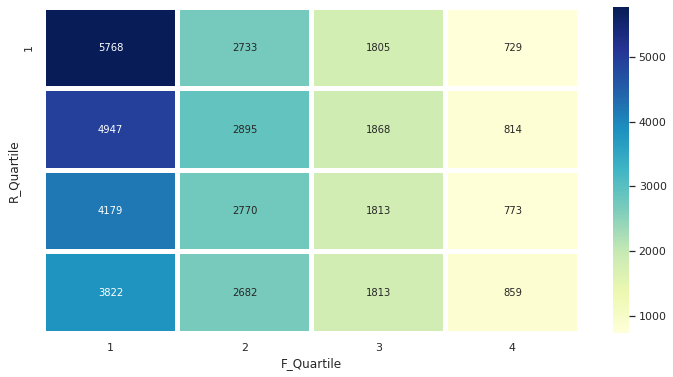

In [14]:
rfm_table = rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='monetary_value', 
                        aggfunc=np.median).applymap(int)
plt.figure(figsize=(12, 6))
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

Мы получили сегментацию пользователей на 4 группы в зависимости от количества заказов, суммарной прибыли и срока последнего посещения продукта, на основе этих данных можно выстроить дальнейшую продуктовую стратегию, разработать мероприятия для перехода пользователей из одной группы в другую.